In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt

In [15]:
n, d = 3, 4

L = 3
mu = 1

M = []
z = []

for idx in range(n):
    temp1 = np.ones(d)
    temp1[idx] = L
    temp2 = np.zeros(d)
    temp2[idx] = L
    
    if idx == 0:
        temp2[d - 1] = L
        
    M.append(np.diag(temp1))
    z.append(- np.diag(temp1) @ temp2)

# Store Data to use for F
dat = (M, z)

M_mean = np.mean(M, axis = 0)
eigen, _ = np.linalg.eig(M_mean.T @ M_mean)
L_total = np.sqrt(np.max(eigen))

mu_total = 1

# Commpute the Optimal Point
x_optimal = - np.linalg.inv(np.mean(M, axis = 0)) @ np.mean(z, axis = 0)

# Uniform Sampling parameters
p_uniform = np.ones(n)/n
delta_uniform = 2 * (L**2)


In [16]:
delta_uniform, L_total

(18, 1.6666666666666667)

In [17]:
def operator_F(x, data, i):
    return data[0][i] @ x + data[1][i]

def SPEG_constant(x_0, x_optimal, L, mu, delta, n, data, operator, prob, iterations = 1000, trials = 5):
    relative_error = np.zeros((trials, iterations))
    initial_error = np.sum((x_0 - x_optimal)**2)
    
    omega_hat = min(.25/L, mu/(18 * delta))
    
    for trial in range(trials):
        i = np.random.choice(range(n), 1, p = prob)[0]
        op = operator(x_0, data, i)
        x = x_0 - omega_hat * op
        
        for k in range(iterations):
            x_mid = x - omega_hat * op
            i = np.random.choice(range(n), 1, p = prob)[0]
            op = operator(x_mid, data, i)
            x = x - omega_hat * op
            
            relative_error[trial, k] = np.sum((x - x_optimal)**2)/ initial_error

    return np.mean(relative_error, axis = 0)

def SPEG_Hsieh(x_0, x_optimal, L, mu, gamma, b, n, data, operator, prob, iterations = 1000, trials = 5):
    relative_error = np.zeros((trials, iterations))
    initial_error = np.sum((x_0 - x_optimal)**2)
    
    for trial in range(trials):
        i = np.random.choice(range(n), 1, p = prob)[0]
        op = operator(x_0, data, i)
        
        x = x_0 - (gamma * op)/b
        
        for k in range(iterations):
            step = gamma/(k + 1 + b)
            x_mid = x - step * op
            i = np.random.choice(range(n), 1, p = prob)[0]
            op = operator(x_mid, data, i)
            x = x - step * op
            
            relative_error[trial, k] = np.sum((x - x_optimal)**2)/ initial_error
    

    return np.mean(relative_error, axis = 0)
        

def SPEG_decreasing(x_0, x_optimal, L, mu, delta, n, data, operator, prob, iterations = 1000, trials = 5):
    relative_error = np.zeros((trials, iterations))
    initial_error = np.sum((x_0 - x_optimal)**2)
    
    omega_hat = min(1/(4 * L), mu / (18 * delta))
    k_0 = math.ceil(iterations / 2)
    
    for trial in range(trials):
        if iterations <= 2/(mu * omega_hat):
            i = np.random.choice(range(n), 1, p = prob)[0]
            op = operator(x_0, data, i)
            x = x_0 - omega_hat * op
            for k in range(iterations):
                x_mid = x - omega_hat * op
                i = np.random.choice(range(n), 1, p = prob)[0]
                op = operator(x_mid, data, i)
                x = x - omega_hat * op
                
                relative_error[trial, k] = np.sum((x - x_optimal)**2)/initial_error
        else:
            i = np.random.choice(range(n), 1, p = prob)[0]
            op = operator(x_0, data, i)
            x = x_0 - omega_hat * op
            for k in range(iterations):
                if k <= k_0:
                    step = omega_hat
                else:
                    step = (4 * omega_hat)/(4 + mu * omega_hat * (k - k_0))
                
                x_mid = x - step * op
                i = np.random.choice(range(n), 1, p = prob)[0]
                op = operator(x_mid, data, i)
                x = x - step * op
                
                relative_error[trial, k] = np.sum((x - x_optimal)**2)/initial_error

    
    return np.mean(relative_error, axis = 0)


def SPEG_switch(x_0, x_optimal, L, mu, delta, n, data, operator, prob, iterations = 1000, trials = 5):
    relative_error = np.zeros((trials, iterations))
    initial_error = np.sum((x_0 - x_optimal)**2)
    
    omega_hat = min(1/(4*L), mu/(18 * delta))
    k_0 = math.ceil(4/(mu * omega_hat))
    
    for trial in range(trials):
        i = np.random.choice(range(n), 1, p = prob)[0]
        op = operator(x_0, data, i)
        x = x_0 - omega_hat * op
        
        for k in range(iterations):
            if k <= k_0:
                step = omega_hat
            else:
                step = (4*k + 2)/(mu * (k + 1)**2)
                
            x_mid = x - step * op
            i = np.random.choice(range(n), 1, p = prob)[0]
            op = operator(x_mid, data, i)
            x = x - step * op
            
            relative_error[trial, k] = np.sum((x - x_optimal)**2)/ initial_error
            
    return np.mean(relative_error, axis = 0)

In [19]:
no_iterations = int(1e5)

SPEG_constant_error = SPEG_constant(np.zeros(d), x_optimal, L_total, mu_total, delta_uniform, n, (M,z), operator_F, p_uniform, iterations = no_iterations, trials = 10)
SPEG_switch_errror =  SPEG_switch(np.zeros(d), x_optimal, L_total, mu_total, delta_uniform, n, (M,z), operator_F, p_uniform, iterations = no_iterations, trials = 10)
#SPEG_error = SPEG_decreasing(np.zeros(2*d), x_optimal, L_total, mu_total, delta_uniform, n, (M,z), operator_F, p_uniform, iterations = no_iterations, trials = 10)

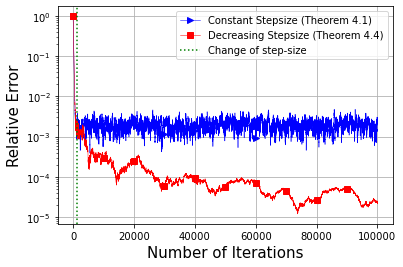

In [20]:
omega_hat = min(1/(4*L_total), mu_total/(18 * delta_uniform))
switch_point = math.ceil(4/(mu_total * omega_hat))


markers_on = np.arange(0, no_iterations, no_iterations/10).astype(int)
plt.plot(np.arange(len(SPEG_constant_error)), SPEG_constant_error, '-b>', markevery = markers_on ,label = 'Constant Stepsize (Theorem 4.1)', linewidth = 0.5)
plt.plot(np.arange(len(SPEG_switch_errror)), SPEG_switch_errror, '-rs', markevery = markers_on, label = 'Decreasing Stepsize (Theorem 4.4)', linewidth = 0.5)
#plt.plot(np.arange(len(SPEG_decreasing_error)), SPEG_decreasing_error, label = 'SPEG Decreasing')
plt.axvline(x= switch_point, color = 'green', linestyle = 'dotted', label = 'Change of step-size')

plt.yscale('log')
plt.grid(True)
plt.ylabel("Relative Error", fontsize = 15)
plt.xlabel("Number of Iterations", fontsize = 15)
plt.legend(fontsize = 10)

plt.savefig(f'constant_switch_comparison_condition = {L_total/mu_total}.pdf', bbox_inches='tight')